In [1]:
import pandas as pd
import time
import warnings
import matplotlib.pyplot as plt
import sklearn.datasets as ds
import sklearn.model_selection as cv
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.svm import LinearSVC
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import (
    AdaBoostClassifier,
    BaggingClassifier,
    ExtraTreesClassifier,
    RandomForestClassifier,
    VotingClassifier,    
)

%matplotlib inline

In [2]:
# loads a CSV file into a pandas table and shows the first few rows so you can inspect the data.

url = "./data_balanced_normalized.csv"
df = pd.read_csv(url)
# loading the 5 rows to see if right thing is loaded
df.head()

,age,hypertension,diabetes,cholesterol_level,obesity,waist_circumference,family_history,sleep_hours,blood_pressure_systolic,blood_pressure_diastolic,...,alcohol_consumption_None,physical_activity_Low,physical_activity_Moderate,dietary_habits_Unhealthy,air_pollution_exposure_Low,air_pollution_exposure_Moderate,stress_level_Low,stress_level_Moderate,EKG_results_Normal,heart_attack
0,-0.191687,-0.611612,-0.473831,0.819943,1.807022,-0.733750,1.527153,1.243393,0.098037,-0.851704,...,0.81734,1.224544,-0.812739,0.816858,1.528958,-0.998836,-0.498499,0.996715,0.495654,0
1,-0.445728,-0.611612,-0.473831,-0.325946,-0.553397,1.350383,-0.654813,-0.882546,1.367177,0.754118,...,-1.22348,1.224544,-0.812739,-1.224203,-0.654040,1.001166,2.006022,-1.003296,-2.017536,0
2,0.231714,-0.611612,-0.473831,0.896336,-0.553397,-1.408028,-0.654813,1.568211,1.099990,-0.249521,...,-1.22348,1.224544,-0.812739,-1.224203,-0.654040,-0.998836,-0.498499,0.996715,0.495654,0
3,-1.885292,-0.611612,-0.473831,-0.147697,-0.553397,-1.162836,1.527153,0.875027,1.033193,-2.557890,...,-1.22348,-0.816630,-0.812739,0.816858,-0.654040,-0.998836,-0.498499,0.996715,0.495654,0
4,-0.530408,-0.611612,-0.473831,-1.650085,-0.553397,-0.978942,-0.654813,0.062720,0.565615,0.352663,...,0.81734,1.224544,-0.812739,-1.224203,-0.654040,1.001166,-0.498499,0.996715,0.495654,0


In [3]:
## predicting if they will had a heart attack based on there health

url = "./data_balanced_normalized.csv"
df = pd.read_csv(url)
X = df.loc[:, df.columns != 'heart_attack']
y = df['heart_attack'] #separer les variables, s'ils ont eu une crise cardiaque ou non
classes = y.unique()
(X_train, X_test, y_train, y_test) = cv.train_test_split(X, y, test_size = .3, random_state = 50) #changer 42, voir si besoin stratify=y
print(y.value_counts(normalize=True)) ## we see that the heart-attack class is balanced

heart_attack
0    0.50011
1    0.49989
Name: proportion, dtype: float64


In [5]:
## code prof, test
def compute_executions_time(function):
    def wrapper():
        start_time = time.time()  # init measuring time
        function()  # execute function
        print(f"\n{time.time() - start_time} seconds")  # print execution time
    return wrapper

In [6]:
modelGaussianNB = GaussianNB().fit(X_train, y_train)
modelKNN = KNeighborsClassifier(metric='manhattan', n_neighbors=29, weights='distance').fit(X_train, y_train)
modelSVM = LinearSVC(C=10, max_iter=10000).fit(X_train, y_train)
modelDT = DecisionTreeClassifier(criterion='entropy').fit(X_train, y_train)

In [ ]:
## code prof
@compute_executions_time
def execute_voting_scheme_different_estimators_grid_search_and_cv(cv = 5): ##cv 50 was not running
    naive_bayes = GaussianNB()
    k_neighbors = KNeighborsClassifier()
    params_space = {
        "n_neighbors": list(range(1, 30, 2)),
        "weights": ["distance", "uniform"]
    }

    clf = GridSearchCV(
        k_neighbors, 
        param_grid = params_space,
        cv = cv,
        n_jobs = -1
    )
    ##clf.fit(X, y)
    clf.fit(X_train, y_train)
    best_parameters_for_knn = clf.best_params_
    print(f"Best Params for Knn: {clf.best_params_} - Accuracy: {clf.best_score_}")

    clf2 = KNeighborsClassifier(
        n_neighbors = best_parameters_for_knn["n_neighbors"],
        weights = best_parameters_for_knn["weights"]
    )
    clf3 = DecisionTreeClassifier(criterion="entropy")

    for clf, label in zip([naive_bayes, clf2, clf3], ["Naive Bayes",f"Knn ({best_parameters_for_knn['n_neighbors']})", "Dec. Tree"]):
        scores = cross_val_score(clf, X_train, y_train, cv=cv, scoring="accuracy")
        print(f"Accuracy: {scores.mean():.3f} [{label}]")

    warnings.filterwarnings("ignore", category=DeprecationWarning)  # Just to avoid warnings

    voting_classifier = VotingClassifier(
        estimators=[
            ("nb", naive_bayes),
            ("knn3", clf2),
            ("dt", clf3)
        ],
        voting = "hard"
    )
    scores = cross_val_score(
        voting_classifier,
        X,
        y,
        cv = cv,
        scoring = "accuracy")
    print("Accuracy: %0.3f [%s]" % (scores.mean() , "Majority Voting"))

execute_voting_scheme_different_estimators_grid_search_and_cv()

Best Params for Knn: {'n_neighbors': 29, 'weights': 'distance'} - Accuracy: 0.7945029366232923
Accuracy: 0.806 [Naive Bayes]
Accuracy: 0.795 [Knn (29)]
Accuracy: 0.810 [Dec. Tree]
Accuracy: 0.833 [Majority Voting]

216.17514753341675 seconds


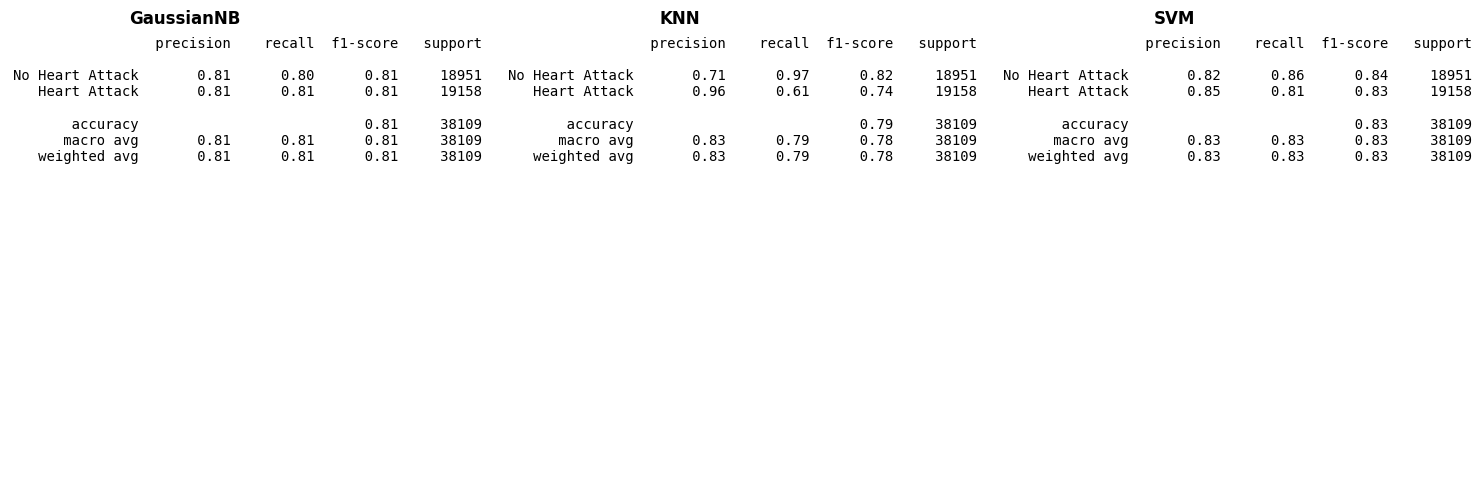

In [8]:
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt

target_names = ['No Heart Attack', 'Heart Attack']

reportGNB = classification_report(y_test, modelGaussianNB.predict(X_test), target_names=target_names)
reportKNN = classification_report(y_test, modelKNN.predict(X_test), target_names=target_names)
reportSVM = classification_report(y_test, modelSVM.predict(X_test), target_names=target_names)

reports = [reportGNB, reportKNN, reportSVM]
titles = ['GaussianNB', 'KNN', 'SVM']

fig, axes = plt.subplots(1, 3, figsize=(15, 5))
axes = axes.flatten()

for i, (report, title) in enumerate(zip(reports, titles)):
    axes[i].text(
        0.01, 0.99,  # Near top-left corner, top aligned
        report,
        fontsize=10,
        family='monospace',
        verticalalignment='top',
        horizontalalignment='left'
    )
    axes[i].axis('off')
    axes[i].set_title(title, fontsize=12, weight='bold')

plt.tight_layout()
plt.show()


In [15]:
# Define base classifiers (untrained here, VotingClassifier will fit)
modelGaussianNB = GaussianNB()
modelKNN = KNeighborsClassifier(metric='manhattan', n_neighbors=29, weights='distance')
modelDT = DecisionTreeClassifier(criterion='entropy')
##modelSVM = SVC(C=10, max_iter=10000, probability = True)
modelSVM = LinearSVC(C=10, max_iter=10000) ##SVC roule pas, donc on ne peut pas faire soft voting

# Create VotingClassifier with these estimators
metaVoting = VotingClassifier(
    estimators=[
        ("GNB", modelGaussianNB),
        ("KNN", modelKNN),
        ("DT", modelDT),
        ("SVM", modelSVM)
    ],
    voting="hard"  # Soft voting requires classifiers to support predict_proba
)

# Define param grid to tune weights for each classifier
params = {
    "weights": [
        [1, 1, 1, 1],
        [2, 1, 1, 1],
        [1, 2, 1, 1],
        [1, 1, 2, 1],
        [1, 1, 1, 2],
        [2, 2, 1, 1],
        [1, 2, 2, 1],
        [1, 1, 2, 2],
        [2, 1, 1, 2],
        [2, 2, 2, 2]
    ]
}

# Create GridSearchCV on the VotingClassifier
modelVoting = GridSearchCV(
    metaVoting,
    param_grid=params,
    cv=10,
    n_jobs=-1
)

# Fit on your training data
modelVoting.fit(X_train, y_train)

print(f"Best Params for VotingClassifier = {modelVoting.best_params_} - Accuracy = {modelVoting.best_score_:.4f}")

Best Params for VotingClassifier = {'weights': [1, 1, 2, 2]} - Accuracy = 0.8433


Bagging 

In [ ]:
## je l'ai rendu plus rapide, mais je pense que les données sont erronées
lb = []
for nest in [1, 2, 5, 10, 20, 50]:
    scores = cross_val_score(
        BaggingClassifier(
            estimator=DecisionTreeClassifier(max_depth=5),
            n_estimators=nest
        ),
        X,
        y,
        cv=5,          # fewer folds for speed
        scoring="accuracy",
        n_jobs=-1      # parallelize CV
    )
    print(f"Accuracy: {scores.mean():.3f} [nº estimators: {nest}]")
    lb.append(scores.mean())


Accuracy: 0.809 [nº estimators: 1]
Accuracy: 0.812 [nº estimators: 2]
Accuracy: 0.809 [nº estimators: 5]
Accuracy: 0.809 [nº estimators: 10]
Accuracy: 0.809 [nº estimators: 20]
Accuracy: 0.809 [nº estimators: 50]
